## Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
%cd /content/gdrive/MyDrive/


/content/gdrive/MyDrive


In [14]:
%cd /content/gdrive/MyDrive/Colab Notebooks/

/content/gdrive/MyDrive/Colab Notebooks


In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [16]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

281
118


## Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Create a dataset
Define some parameters for the loader:

In [19]:
batch_size = 32
img_height = 180
img_width = 180

In [20]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 281 files belonging to 2 classes.
Using 225 files for training.


In [21]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 281 files belonging to 2 classes.
Using 56 files for validation.


In [22]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma']


In [23]:
print(type(train_ds))
print(train_ds)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Visualize the data
##### Todo, create a code to visualize one instance of all the nine classes present in the dataset

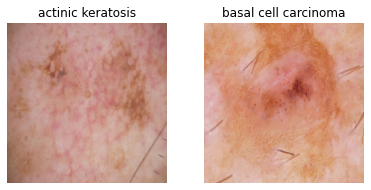

In [25]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
i=0
for k in class_names:
  for images, labels in train_ds.unbatch().take(1793):
    if class_names[labels] == k:
      i=i+1
      ax = plt.subplot(3, 3, i)
      plt.imshow(images.numpy().astype("uint8"))
      plt.title(class_names[labels])
      plt.axis("off")
      break

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
##### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [27]:
### Your code goes here
num_classes = 9

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_width,img_height,3)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile the model

In [28]:
### Todo, choose an appropirate optimiser and loss function
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [29]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 118336)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

## Train the model

In [30]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
8/8 [==============================] - 22s 3s/step - loss: 2.6812 - accuracy: 0.3792 - val_loss: 0.9423 - val_accuracy: 0.5179
Epoch 2/20
8/8 [==============================] - 9s 1s/step - loss: 0.8386 - accuracy: 0.5084 - val_loss: 0.7308 - val_accuracy: 0.5179
Epoch 3/20
8/8 [==============================] - 9s 1s/step - loss: 0.8288 - accuracy: 0.4137 - val_loss: 0.8519 - val_accuracy: 0.5179
Epoch 4/20
8/8 [==============================] - 9s 1s/step - loss: 0.8312 - accuracy: 0.4485 - val_loss: 0.9222 - val_accuracy: 0.4821
Epoch 5/20
8/8 [==============================] - 9s 1s/step - loss: 0.6566 - accuracy: 0.6548 - val_loss: 0.9562 - val_accuracy: 0.4821
Epoch 6/20
8/8 [==============================] - 9s 1s/step - loss: 0.6540 - accuracy: 0.6421 - val_loss: 0.7226 - val_accuracy: 0.4821
Epoch 7/20
8/8 [==============================] - 9s 1s/step - loss: 0.6429 - accuracy: 0.6440 - val_loss: 0.7452 - val_accuracy: 0.4464
Epoch 8/20
8/8 [========================

## Visualizing training results

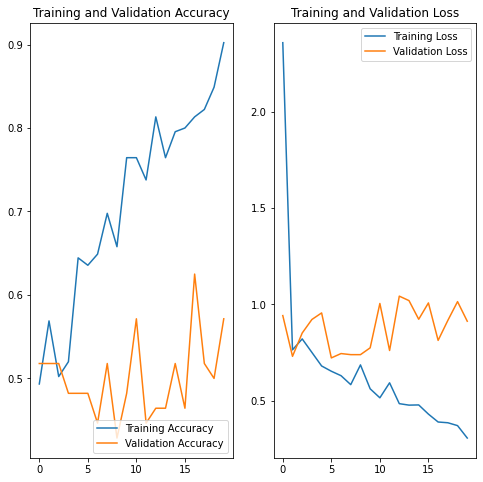

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
Model is overfitting since training accuracy is 89% while validation accuracy is 57%

In [32]:

IMG_SIZE = 180


data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_SIZE, 
                                                              IMG_SIZE,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),      
  ]
)

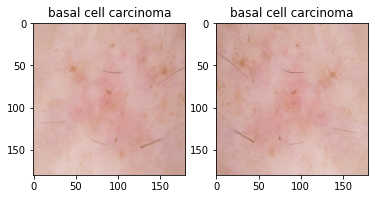

In [33]:
for images, labels in train_ds.take(1):
  result = data_augmentation(images)
  aug_image_batch = next(iter(result))
  image_batch = next(iter(images))
  ax = plt.subplot(1, 2, 1)
  plt.imshow(aug_image_batch.numpy().astype("uint8"))
  plt.title(class_names[labels[0]])
  ax = plt.subplot(1, 2, 2)
  plt.imshow(image_batch.numpy().astype("uint8"))
  plt.title(class_names[labels[0]])

### Todo:
### Create the model, compile and train the model

In [34]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
num_classes = 9


model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_width,img_height,3)),
  data_augmentation,
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.1),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [35]:
### Todo, choose an appropirate optimiser and loss function
### Todo, choose an appropirate optimiser and loss function
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Training the model

In [36]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
8/8 [==============================] - 11s 1s/step - loss: 10.3623 - accuracy: 0.3663 - val_loss: 0.9448 - val_accuracy: 0.4821
Epoch 2/20
8/8 [==============================] - 10s 1s/step - loss: 1.0347 - accuracy: 0.6072 - val_loss: 1.2705 - val_accuracy: 0.4821
Epoch 3/20
8/8 [==============================] - 10s 1s/step - loss: 0.7978 - accuracy: 0.6468 - val_loss: 0.9370 - val_accuracy: 0.4821
Epoch 4/20
8/8 [==============================] - 10s 1s/step - loss: 0.6681 - accuracy: 0.6031 - val_loss: 0.7873 - val_accuracy: 0.4821
Epoch 5/20
8/8 [==============================] - 10s 1s/step - loss: 0.6832 - accuracy: 0.5888 - val_loss: 0.7565 - val_accuracy: 0.4821
Epoch 6/20
8/8 [==============================] - 10s 1s/step - loss: 0.6506 - accuracy: 0.6348 - val_loss: 0.7376 - val_accuracy: 0.4821
Epoch 7/20
8/8 [==============================] - 10s 1s/step - loss: 0.6688 - accuracy: 0.5869 - val_loss: 0.7429 - val_accuracy: 0.4821
Epoch 8/20
8/8 [=================

### Visualizing the results

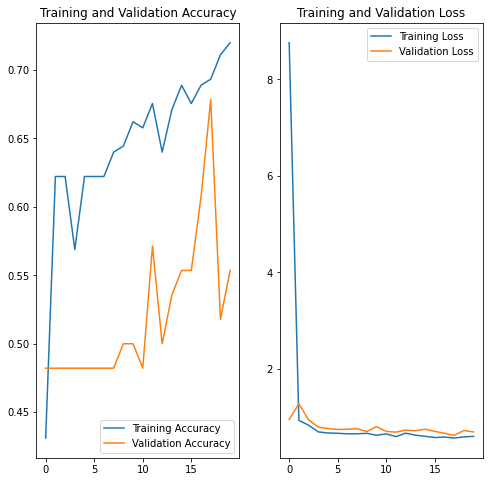

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After data agumentation(train acc:70% val:56%) and dropouts, model became more general. Gap between train and val accuracy reduced a lot just by applying transformations to training images. Train accuracy 70% val accuracy = 55%. Still need to improve accuracy.

### Todo: Find the distribution of classes in the training dataset.

### Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

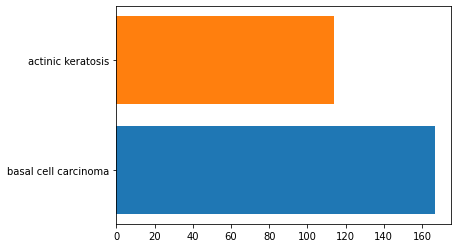

In [38]:
import os
path = 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
mn = 0
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # get all directories 
for folder in folders:
    contents = os.listdir(os.path.join(path,folder)) # get list of contents
    if len(contents) >= mn: # if greater than the limit, print folder and number of contents
        plt.barh(folder,len(contents))


Todo: Write your findings here:
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?
 basal cell carcnoma dominates proportionate number of samples. actinic keratosis has least number of samples

Todo: Rectify the class imbalance

In [40]:
!pip install Augmentor

In [41]:

path_to_training_dataset="CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9F5CBA8890>:   0%|          | 1/500 [00:00<01:19,  6.25 Samples/s]

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F590A6B50>: 100%|██████████| 500/500 [00:20<00:00, 23.96 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 167 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F59129B90>: 100%|██████████| 500/500 [00:19<00:00, 25.32 Samples/s]


In [42]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

1000


In [43]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[1]

'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027526.jpg_38e52dc7-4700-478a-b44d-65e1780de473.jpg'

In [44]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[1]

'basal cell carcinoma'

In [45]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [46]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [47]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [48]:
new_df['Label'].value_counts()

basal cell carcinoma    667
actinic keratosis       614
Name: Label, dtype: int64

In [49]:
batch_size = 32
img_height = 180
img_width = 180

In [50]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1281 files belonging to 2 classes.
Using 1025 files for training.


In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1281 files belonging to 2 classes.
Using 256 files for validation.


In [52]:
### Your code goes here
num_classes = 9

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_width,img_height,3)),
  data_augmentation,
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.1),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [53]:
## your code goes here
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [54]:

epochs = 30
## Your code goes here, use 50 epochs.
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
33/33 [==============================] - 53s 2s/step - loss: 3.3596 - accuracy: 0.5106 - val_loss: 0.7701 - val_accuracy: 0.4805
Epoch 2/30
33/33 [==============================] - 52s 2s/step - loss: 0.7381 - accuracy: 0.5273 - val_loss: 0.8231 - val_accuracy: 0.5156
Epoch 3/30
33/33 [==============================] - 52s 2s/step - loss: 0.8365 - accuracy: 0.5184 - val_loss: 0.7252 - val_accuracy: 0.5273
Epoch 4/30
33/33 [==============================] - 51s 2s/step - loss: 0.7969 - accuracy: 0.5225 - val_loss: 0.7392 - val_accuracy: 0.5195
Epoch 5/30
33/33 [==============================] - 52s 2s/step - loss: 0.7091 - accuracy: 0.5354 - val_loss: 0.6988 - val_accuracy: 0.6250
Epoch 6/30
33/33 [==============================] - 53s 2s/step - loss: 0.6397 - accuracy: 0.6350 - val_loss: 0.7460 - val_accuracy: 0.5469
Epoch 7/30
33/33 [==============================] - 52s 2s/step - loss: 0.7161 - accuracy: 0.5622 - val_loss: 0.7075 - val_accuracy: 0.6094
Epoch 8/30
33/33 [==

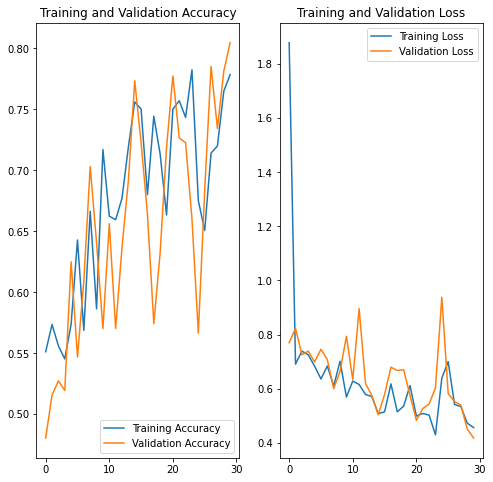

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Overfitting issue resolved by data augmentation and dropouts.
- Reducing class imbalance helped model learnt features of each class with comparable weightage.
- Accuracy is improved by adding 500 images for each class reducing class imbalance. 
- Train accuracy : 77.6% Validation accuracy : 80%
- Data augmentation helped model learnt different variations of classes thus not mugging up train data.
